### This notebook shows how to use recurrent neural network for multi-step forecast of power consumption.

In [1]:
import sys
import numpy as np
import pandas as pd

from datetime import timedelta as td
import dateutil.parser

import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2 as reg_l2
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

print('Python version:', sys.version)
print("TensorFlow {}".format(tf.__version__))

Python version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
TensorFlow 2.3.0


# Load data

The dataset was taken from https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
# data for analysis
df = pd.read_csv('data/energy/EKPC_hourly.csv', parse_dates=['Datetime'], index_col=0).sort_index()

print(df.head())
print()
print(df.tail())

                     EKPC_MW
Datetime                    
2013-06-01 01:00:00   1166.0
2013-06-01 02:00:00   1098.0
2013-06-01 03:00:00   1036.0
2013-06-01 04:00:00   1023.0
2013-06-01 05:00:00    949.0

                     EKPC_MW
Datetime                    
2018-08-02 20:00:00   1815.0
2018-08-02 21:00:00   1769.0
2018-08-02 22:00:00   1756.0
2018-08-02 23:00:00   1619.0
2018-08-03 00:00:00   1448.0


# Explore data

In [3]:
print(df.info())
print()
print('shape', df.shape)
print('missing values', df['EKPC_MW'].isna().sum())
print('duplicated', sum(df.index.duplicated()))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45334 entries, 2013-06-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
EKPC_MW    45334 non-null float64
dtypes: float64(1)
memory usage: 708.3 KB
None

shape (45334, 1)
missing values 0
duplicated 4


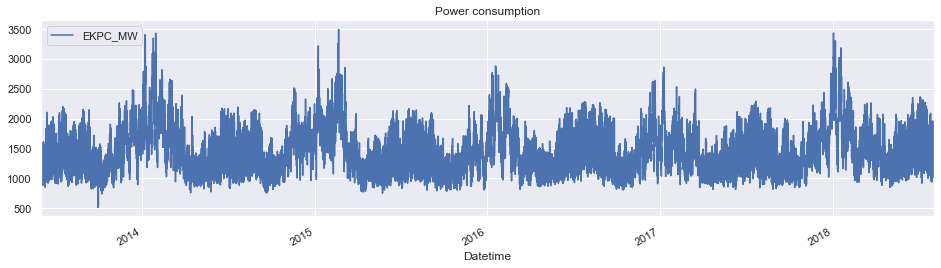

In [4]:
# Data visualization
df['EKPC_MW'].plot(figsize=(16,4),legend=True)
plt.title('Power consumption')
plt.show()

# Missing values treatment

In [5]:
# check missing dates
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

all_dates.difference(df.index)

DatetimeIndex(['2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [6]:
# missing values using reindexing and interpolation
df = df.loc[~df.index.duplicated(),:].reindex(all_dates).interpolate(method='linear')

print('missing values', df['EKPC_MW'].isna().sum())

missing values 0


# Create pipeline

In [7]:
# transformer function to encode calendar data  lambda x: int(x.day/7)
trans_func = lambda df: np.concatenate([df.index.month.values.reshape(-1,1),
                                        (df.index.day.values/7).astype(int).reshape(-1,1),
                                        df.index.weekday.values.reshape(-1,1),
                                        df.index.hour.values.reshape(-1,1)], axis=1)

# feature transformer pipeline
feature_transformer = make_pipeline(FunctionTransformer(func=trans_func), OneHotEncoder(sparse=False))

# target transformer
target_transformer = MinMaxScaler(feature_range=(-1, 1))

# Split data

In [8]:
'''
Data is split as follows:
from 2013-06-01 to 2016-01-01 for training
from 2016-01-01 to 2017-01-01 for validation
from 2017-01-01 to 2018-08-03 for testing
'''

# panda data
df_train = df[:"2016-01-01"]
df_valid = df["2016-01-01":"2017-01-01"]
df_test = df["2017-01-01":]

# fit transformers on training data and perform transformations creating numpy arrays
# train data
X_train = feature_transformer.fit_transform( df_train )
y_train = target_transformer.fit_transform( df_train['EKPC_MW'].values.reshape(-1,1) )

# validation data
X_valid = feature_transformer.transform(df_valid)
y_valid = target_transformer.transform(df_valid['EKPC_MW'].values.reshape(-1,1))

# test data
X_test = feature_transformer.transform(df_test)
y_test = target_transformer.transform(df_test['EKPC_MW'].values.reshape(-1,1))

# print shape of arrays
print('X_train = {} y_train = {}'.format(X_train.shape, y_train.shape))
print('X_valid = {} y_valid = {}'.format(X_valid.shape, y_valid.shape))
print('X_test = {} y_test = {}'.format(X_test.shape, y_test.shape))

X_train = (22679, 48) y_train = (22679, 1)
X_valid = (8808, 48) y_valid = (8808, 1)
X_test = (13897, 48) y_test = (13897, 1)


In [9]:
# organize data in a way suitable for tensorflow model
def get_data_model(x_vals, y_vals, Tx=24, Ty=24):

    x_encoder, y_encoder, x_decoder, y_decoder = [], [], [], []
    
    for i in range(Tx+1, x_vals.shape[0]-Ty):
        x = x_vals[i-Tx:i, :]
        y = y_vals[i-1-Tx:i-1].reshape(-1, 1)
        f = np.concatenate((x, y), axis=1)
        
        x_encoder.append(f)
        y_encoder.append(y_vals[i-Tx:i])
        
        x_decoder.append(x_vals[i:i+Ty,:])
        y_decoder.append(y_vals[i:i+Ty])
    
    return np.array(x_encoder), np.array(y_encoder), np.array(x_decoder), np.array(y_decoder)


# get data sets in numpy arrays
x_encoder_train, y_encoder_train, x_decoder_train, y_decoder_train = get_data_model(X_train, y_train)
x_encoder_valid, y_encoder_valid, x_decoder_valid, y_decoder_valid = get_data_model(X_valid, y_valid)
x_encoder_test, y_encoder_test, x_decoder_test, y_decoder_test = get_data_model(X_test, y_test)

# data for tensorflow
x_train_tf, y_train_tf = [x_encoder_train, x_decoder_train], y_decoder_train
x_valid_tf, y_valid_tf = [x_encoder_valid, x_decoder_valid], y_decoder_valid
x_test_tf, y_test_tf = [x_encoder_test, x_decoder_test], y_decoder_test

# print shape of array
print('x_encoder_train.shape = ', x_encoder_train.shape)
print('y_encoder_train.shape = ', y_encoder_train.shape)
print('x_decoder_train.shape = ', x_decoder_train.shape)
print('y_decoder_train.shape = ', y_decoder_train.shape)
print()
print('x_encoder_valid.shape = ', x_encoder_valid.shape)
print('y_encoder_valid.shape = ', y_encoder_valid.shape)
print('x_decoder_valid.shape = ', x_decoder_valid.shape)
print('y_decoder_valid.shape = ', y_decoder_valid.shape)
print()
print('x_encoder_test.shape = ', x_encoder_test.shape)
print('y_encoder_test.shape = ', y_encoder_test.shape)
print('x_decoder_test.shape = ', x_decoder_test.shape)
print('y_decoder_test.shape = ', y_decoder_test.shape)

x_encoder_train.shape =  (22630, 24, 49)
y_encoder_train.shape =  (22630, 24, 1)
x_decoder_train.shape =  (22630, 24, 48)
y_decoder_train.shape =  (22630, 24, 1)

x_encoder_valid.shape =  (8759, 24, 49)
y_encoder_valid.shape =  (8759, 24, 1)
x_decoder_valid.shape =  (8759, 24, 48)
y_decoder_valid.shape =  (8759, 24, 1)

x_encoder_test.shape =  (13848, 24, 49)
y_encoder_test.shape =  (13848, 24, 1)
x_decoder_test.shape =  (13848, 24, 48)
y_decoder_test.shape =  (13848, 24, 1)


# Build tensorflow model

## Architecture: sequence to sequence (Seq2Seq) 

The model consists of encoder and decoder
<!--- 

-->
<img src="images/energy/seq2seq_l2.png" width="700" height="400" style="float: center"/>

In [10]:
def build_model(nx_encoder, nx_decoder, Tx=24, Ty=24):
    """
    params:
    nx_encoder - number of features in encoder
    nx_decoder - number of features in decoder
    Tx - length of input sequence
    Ty - length of output sequence
    """

    # inputs
    x_encoder = Input(shape=(Tx, nx_encoder))
    x_decoder = Input(shape=(Ty, nx_decoder))

    # number of hidden units
    num_units = [128, 64]
    
    # II - ENCODER TRANSFORMATIONS
    x1 = x_encoder
    states = []
    for n_units in num_units:        
        #o, h, c = LSTM(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3))(x1)        
        #states.append([h, c])        
        o, h = GRU(n_units, return_sequences=True, return_state=True, kernel_regularizer=reg_l2(1e-3))(x1)
        states.append(h)
        x1 = o
        
    y_encoder = Dense(1, activation='linear', kernel_regularizer=reg_l2(1e-3))(x1) # for pretraining
    
    # III - DECODER TRANSFORMATIONS
    x2 = x_decoder
    for i, n_units in enumerate(num_units):           
        #o = LSTM(n_units, return_sequences=True, kernel_regularizer=reg_l2(1e-3))(x2, initial_state=states[i])
        o = GRU(n_units, return_sequences=True, kernel_regularizer=reg_l2(1e-3))(x2, initial_state=states[i])
        x2 = o        
        
    y_decoder = Dense(1, activation='linear', kernel_regularizer=reg_l2(1e-3))(x2)
    
    # IV - models
    model = {}
    model['encoder'] = Model(inputs=x_encoder, outputs=y_encoder)
    model['encoder'].compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    model['encoder_decoder'] = Model(inputs=[x_encoder, x_decoder], outputs=y_decoder)    
    model['encoder_decoder'].compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
    
    return model


# model
seq2seq = build_model(nx_encoder=x_encoder_train.shape[2], nx_decoder=x_decoder_train.shape[2])
seq2seq['encoder_decoder'].summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 49)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24, 48)]     0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 24, 128), (N 68736       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 24, 128)      68352       input_2[0][0]                    
                                                                 gru[0][1]             

## Train the model

### First pretrain encoder

In [ ]:
fname_best_encoder = 'models/energy/multistep/seq2seq/encoder/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_encoder,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# train encoder
seq2seq['encoder'].fit(x_encoder_train, np.squeeze(y_encoder_train),
                       validation_data=(x_encoder_valid, np.squeeze(y_encoder_valid)), 
                       epochs=30, shuffle=False, callbacks=callbacks, verbose=0)

### Next train encoder-decoder model

In [ ]:
fname_best_seq2seq = 'models/energy/multistep/seq2seq/best'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=fname_best_seq2seq,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
]

# Load pretrained encoder
seq2seq['encoder'].load_weights(fname_best_encoder)

# train encoder-decoder model
history = seq2seq['encoder_decoder'].fit(x_train_tf, y_train_tf, 
                                         validation_data=(x_valid_tf, y_valid_tf), 
                                         epochs=170, shuffle=False, callbacks=callbacks, verbose=0)

# Load the weights with the best error on validation data
seq2seq['encoder_decoder'].load_weights(fname_best_seq2seq)

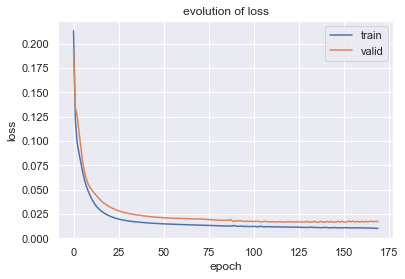

In [13]:
# summarize learning history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('evolution of loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# Analyse the results

In [14]:
# compute predictions and errors
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model = seq2seq['encoder_decoder']

# train data
y_train_true = target_transformer.inverse_transform( y_decoder_train.squeeze() )
y_train_pred = target_transformer.inverse_transform( model.predict(x_train_tf).squeeze() )
print("Train data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_train_true, y_train_pred)))

# valid data
y_valid_true = target_transformer.inverse_transform( y_decoder_valid.squeeze() )
y_valid_pred = target_transformer.inverse_transform( model.predict(x_valid_tf).squeeze() )
print("Valid data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_valid_true, y_valid_pred)))

# test data
y_test_true = target_transformer.inverse_transform( y_decoder_test.squeeze() )
y_test_pred = target_transformer.inverse_transform( model.predict(x_test_tf).squeeze() )
print("Test data: MAPE={:.4f}".format(mean_absolute_percentage_error(y_test_true, y_test_pred)))

Train data: MAPE=7.9960
Valid data: MAPE=8.8756
Test data: MAPE=9.4536


## Plot individual 24-hour forecasts

In [15]:
# This function is used to plot results
def plot_predictions(y_true, y_pred, title, xlim=[0, 23], ylim=None):
    plt.figure(figsize=(12,4))
    plt.plot(y_true, color='blue', label='True')
    plt.plot(y_pred, color='red', alpha=0.6, label='Pred')    
    plt.title(title)    
    plt.xlabel('time')
    plt.ylabel('power')
    plt.xlim(xlim)
    plt.ylim(ylim)    
    plt.legend()
    plt.show()

ylim = [target_transformer.data_min_, target_transformer.data_max_]

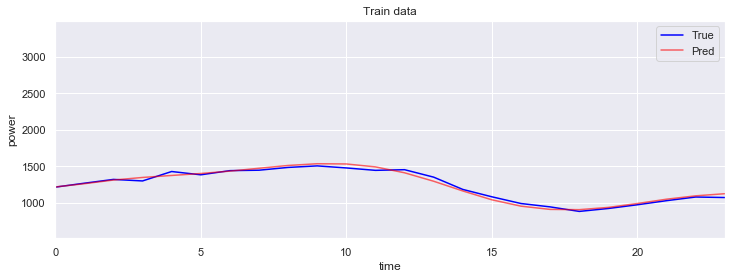

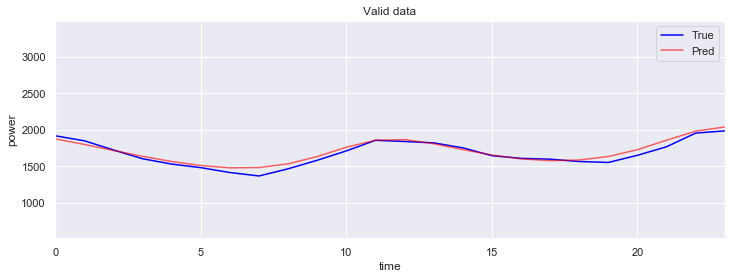

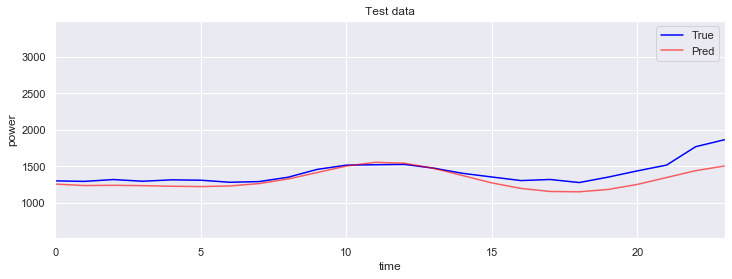

In [21]:
idx = 32 # index of an example in a dataset

# plot train data
plot_predictions(y_train_true[idx,:], y_train_pred[idx,:], "Train data", ylim=ylim)

# plot valid data
plot_predictions(y_valid_true[idx,:], y_valid_pred[idx,:], "Valid data", ylim=ylim)

# plot test data
plot_predictions(y_test_true[idx,:], y_test_pred[idx,:], "Test data", ylim=ylim)

## Plot all 24-hour forecasts concatenating the results 

In [17]:
# concatenate all true values and all predictions

# true values
y_all_train_true = y_train_true.flatten()
y_all_valid_true = y_valid_true.flatten()
y_all_test_true = y_test_true.flatten()

# predicted values
y_all_train_pred = y_train_pred.flatten()
y_all_valid_pred = y_valid_pred.flatten()
y_all_test_pred = y_test_pred.flatten()

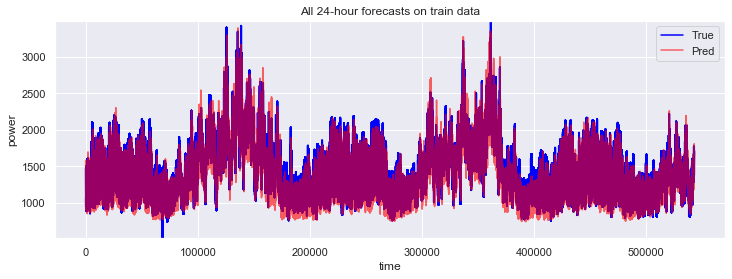

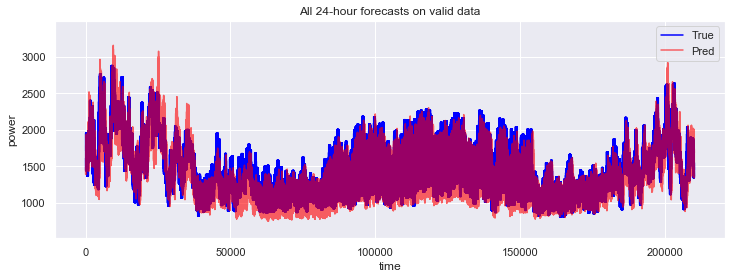

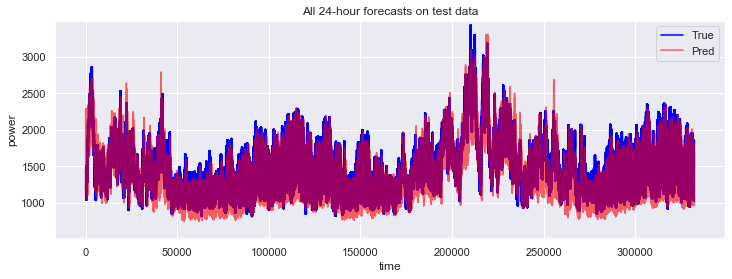

In [18]:
# plot the results
plot_predictions(y_all_train_true, y_all_train_pred, title='All 24-hour forecasts on train data', xlim=None, ylim=ylim)
plot_predictions(y_all_valid_true, y_all_valid_pred, title='All 24-hour forecasts on valid data', xlim=None, ylim=ylim)
plot_predictions(y_all_test_true, y_all_test_pred, title='All 24-hour forecasts on test data', xlim=None, ylim=ylim)